In [1]:
import os

import numpy as np
from sklearn.model_selection import train_test_split

from experience import load_experience
from lib.action_space import is_do_nothing_action
from lib.constants import Constants as Const
from lib.data_utils import make_dir, env_pf, extract_target_windows
from lib.dc_opf import load_case
from lib.run_utils import create_logger
from lib.visualizer import Visualizer, pprint

Visualizer()

experience_dir = make_dir(os.path.join(Const.EXPERIENCE_DIR, "data-aug"))
results_dir = make_dir(os.path.join(Const.RESULTS_DIR, "binary-linear"))

agent_name = "agent-mip"
case_name = "l2rpn_2019_art"
env_dc = True
verbose = False

case_results_dir = make_dir(os.path.join(results_dir, f"{case_name}-{env_pf(env_dc)}"))
create_logger(logger_name=f"{case_name}-{env_pf(env_dc)}", save_dir=case_results_dir)

case, collector = load_experience(case_name, agent_name, experience_dir, env_dc=env_dc)
obses, actions, rewards, dones = collector.aggregate_data()

rhos = np.vstack([obs.rho for obs in obses])
pprint("    - Number of chronics:", dones.sum())
pprint("    - Observations:", len(obses))
pprint("    - Rhos:", rhos.shape)
pprint("    - Number of chronics:", dones.sum())
pprint("    - Observations:", len(obses))


L2RPN_2019_ART (dc)


--------------------------------------------------------------------------------
                                        Loading Experience
--------------------------------------------------------------------------------
    - Loading chronics:                 ./experience/data-aug/l2rpn_2019_art-dc/agent-mip-chronic-****
Chronic:                                0
        - O A R D:                      6913	6912	(6912,)	(6912,)
Chronic:                                1
        - O A R D:                      201	200	(200,)	(200,)
Chronic:                                3
        - O A R D:                      8065	8064	(8064,)	(8064,)
Chronic:                                4
        - O A R D:                      8065	8064	(8064,)	(8064,)
Chronic:                                7
        - O A R D:                      7777	7776	(7776,)	(7776,)
Chronic:                                10
        - O A R D:                      3104	3103	(3103,)	(3103,)
Chronic:


L2RPN_2019_ART (ac)



Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


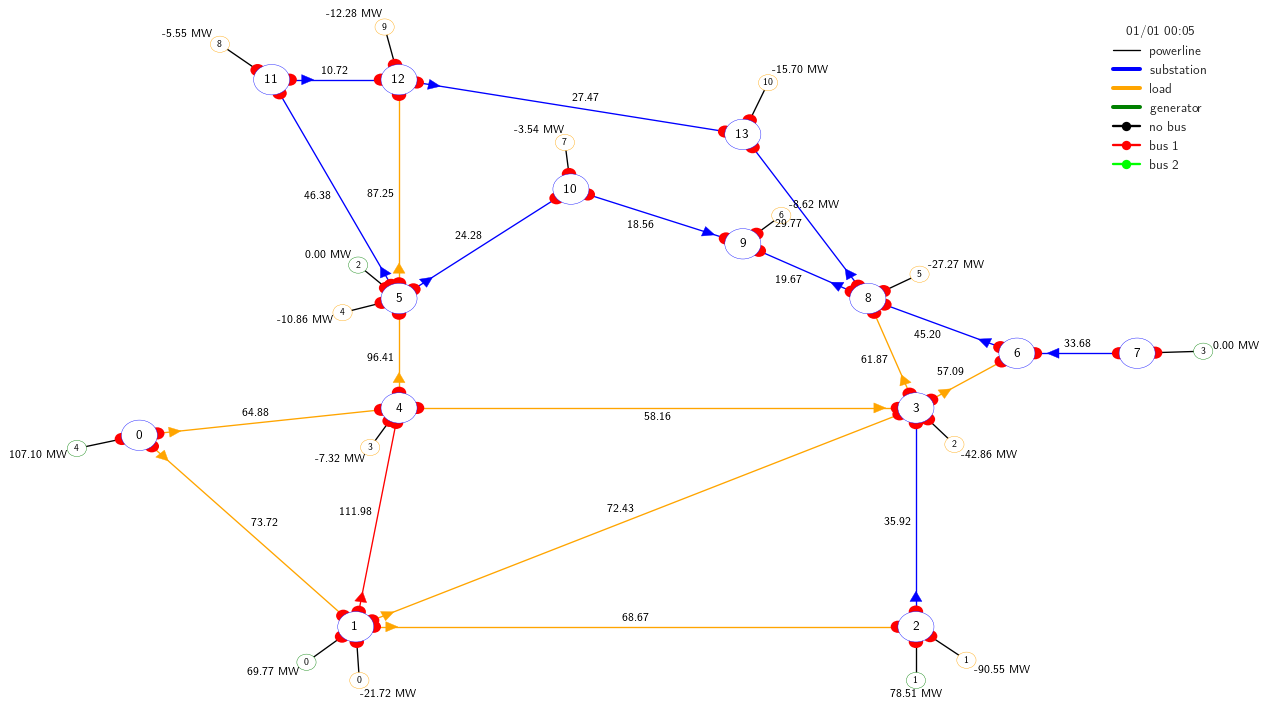

In [2]:
case = load_case(case_name)
env = case.env

env.reset()
fig = env.render()

    - Line 9                            4	5	0.650 + 0.145
        - Critical:                     121	0.064 % / 23.866 %
        - Overloaded:                   4	0.002 % / 3.810 %
    - Line 3                            1	3	0.516 + 0.153
        - Critical:                     72	0.038 % / 14.201 %
        - Overloaded:                   23	0.012 % / 21.905 %
    - Line 1                            0	4	0.507 + 0.136
        - Critical:                     68	0.036 % / 13.412 %
        - Overloaded:                   14	0.007 % / 13.333 %


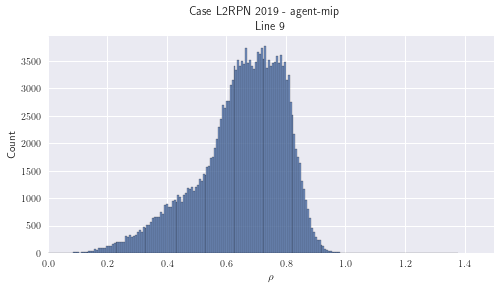

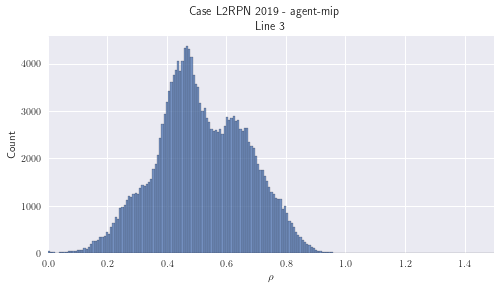

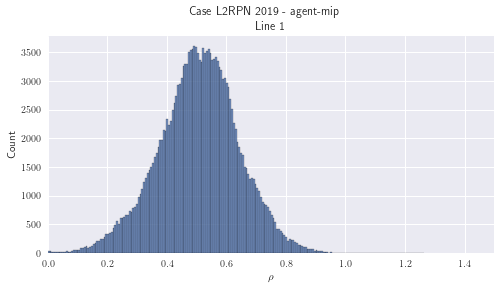

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

critical_rho = 0.95
means = rhos.mean(axis=0)
stds = rhos.std(axis=0)
criticals = np.greater(rhos, critical_rho).sum(axis=0)
overloads = np.greater(rhos, 1.0).sum(axis=0)

n_critical_all = criticals.sum()
n_overloaded_all = overloads.sum()

max_ids = np.argsort(criticals)
sorted_max_ids = np.sort(max_ids) 

for line_id in reversed(max_ids[-3:]):
    sub_or = env.line_or_to_subid[line_id]
    sub_ex = env.line_ex_to_subid[line_id]
    
    critical = np.greater(rhos[:, line_id], critical_rho)
    overloaded = np.greater(rhos[:, line_id], 1.0)
    
    n_critical = critical.sum()
    n_overloaded = overloaded.sum()
    
    if n_critical > 0:
        pprint(f"    - Line {line_id}", sub_or, sub_ex, "{:.3f} + {:.3f}".format(means[line_id], stds[line_id]))    
        pprint("        - Critical:", n_critical, 
               "{:.3f} % / {:.3f} %".format(100 * critical.mean(), 100 * n_critical / n_critical_all))
        pprint("        - Overloaded:", n_overloaded, 
               "{:.3f} % / {:.3f} %".format(100 * overloaded.mean(), 100 * n_overloaded / n_overloaded_all))
        
    fig, ax = plt.subplots(figsize=Const.FIG_SIZE)
    sns.histplot(data=rhos[:, line_id], ax=ax)
    ax.set_xlabel(r"$\rho$")
    ax.set_ylabel(r"Count")
    ax.set_xlim(left=0.0, right=1.5)
    ax.set_title(f"Line {line_id}")
    fig.suptitle(f"{case.name} - {agent_name}")